# Зависимости

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Embedding, Conv1D, MaxPooling1D,
                                     GlobalAveragePooling1D, Dropout,
                                     Dense, LSTM, Bidirectional)
from tensorflow.keras import utils
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files
from google.colab import drive

from mycsv import split_file
from transform import Converter
from dataset import load_dataset

# Загрузка и конвертация данных

Разделение датасета на тренировочную выборку и тестовую.

In [ ]:
split_file('dataset.csv', split_ratio=0.8)

После разделения датасета в дериктории появиться два файла (тренировочный сет и тестовый).

* `maxlen` задает максимальную длину последовательности узлов функции (средняя длина последовательности ~50)

* `verbose` задает многословность функций обработчиков (то столько будет выводится информации во время обратоки); доступные значения от 0 до 3

In [ ]:
TRAIN_PATH = 'train_dataset.csv'
TEST_PATH = 'test_dataset.csv'
maxlen = 300
verbose = 0

Загрузка и трансформация данных для обучения.

In [ ]:
dataset = load_dataset(TRAIN_PATH, TEST_PATH, maxlen, verbose=verbose)
x_train, y_train, x_test, y_test, data_converter, marks_converter = dataset

Сериализация словарей конвертеров.

In [ ]:
data_converter.to_file()
marks_converter.to_file()

# Загрузка ранее обученной модели и данных

Загрузка ранее использованных данных и их словарей. (Выполняется при загрузке ранее использованного датасета с ранее обученной моделью)

In [ ]:
classes_num = 0
tokens_num = 0

data_converter = Converter()
marks_converter = Converter()

data_converter.from_file(f'dictionary_{classes_num}')
marks_converter.from_file(f'dictionary_{tokens_num}')

dataset = load_dataset(TRAIN_PATH, TEST_PATH, 
                       maxlen, 
                       data_converter,
                       marks_converter, 
                       verbose=1)
x_train, y_train, x_test, y_test, data_converter, marks_converter = dataset

Загрузка модели нейронной сети из файла.

In [ ]:
MODEL_PATH = ''
model = load_model(MODEL_PATH)

# Выбор модели нейронной сети

In [ ]:
# CNN-Model
model_name = 'fnp_cnn'
model = Sequential()
model.add(Embedding(len(data_converter), 32, input_length=maxlen))
model.add(Conv1D(100, 10, activation='relu', padding='same'))
model.add(Conv1D(100, 10, activation='relu', padding='same'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu', padding='same'))
model.add(Conv1D(160, 10, activation='relu', padding='same'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(len(marks_converter), activation='softmax'))

In [ ]:
# LSTM-Model
model_name = 'fnp_lstm'
model = Sequential()
model.add(Embedding(len(data_converter), 32, input_length=maxlen))
model.add(LSTM(128, return_sequences=True, dropout=0.2))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(len(marks_converter), activation='softmax'))

# Экспериментальные модели

In [ ]:
# BiLSTM-Model
model_name = 'fnp_bilstm'
model = Sequential()
model.add(Embedding(len(data_converter), 64, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3)))
model.add(Bidirectional(LSTM(128, dropout=0.3)))
model.add(Dense(len(marks_converter), activation='softmax'))

# Обучение нейронной сети

In [ ]:
print('Название модели:', model_name)
model.summary()

Название модели: fnp_bilstm
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 64)           633152    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 256)          197632    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_6 (Dense)              (None, 101)               25957     
Total params: 1,250,981
Trainable params: 1,250,981
Non-trainable params: 0
_________________________________________________________________


**Компиляция модели**

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
graph_history = {'accuracy': [], 'val_accuracy': []}

**Обучение модели**

In [ ]:
history = model.fit( x_train, y_train,
                    validation_data = (x_test, y_test),
                    epochs=5,
                    batch_size=100,
                    shuffle=True,
                    verbose=1)
graph_history['accuracy'].extend(history.history['accuracy'])
graph_history['val_accuracy'].extend(history.history['val_accuracy'])

**Обучение модели с автосохранением**

In [ ]:
total_epochs = 30
period = 1

e = 0
while total_epochs > e:
  history = model.fit( x_train, y_train,
                      validation_data = (x_test, y_test),
                      epochs=period,
                      batch_size=20,
                      shuffle=True,
                      verbose=1)
  graph_history['accuracy'].extend(history.history['accuracy'])
  graph_history['val_accuracy'].extend(history.history['val_accuracy'])
  e = len(graph_history['accuracy'])
  save_model_gdrive(model, 
              name=model_name,
              maxlen=maxlen,
              epochs=len(graph_history['accuracy']),
              precent=int(graph_history['val_accuracy'][-1]*1000)
           )

6865/6865 [==============================] - 389s 57ms/step - loss: 0.4330 - accuracy: 0.8771 - val_loss: 1.0276 - val_accuracy: 0.8003


# Проверка качества обучения

In [ ]:
def print_graph(graph_history):
  plt.plot(graph_history['accuracy'],
          label='Доля верных ответов на обучающем наборе')
  plt.plot(graph_history['val_accuracy'],
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

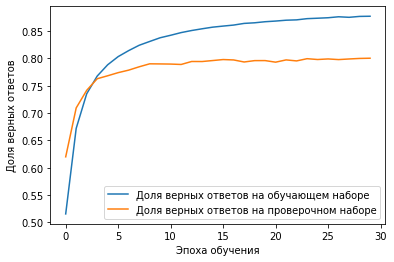

476/476 [==============================] - 10s 20ms/step - loss: 1.0276 - accuracy: 0.8003
Доля верных ответов на тестовых данных составляет: 80.0263 %


In [ ]:
print_graph(graph_history)
scores = model.evaluate(x_test, y_test, verbose=1)
print('Доля верных ответов на тестовых данных составляет:',round(scores[1]* 100, 4),'%')

# Сохраннение модели нейронной сети

Сохранение нейронной сети в директорию.

In [ ]:
def save_model(model, name, maxlen, epochs, precent):
  model.save(f'models/{name}_maxlen{maxlen}_e{epochs}_p{precent}.h5')

In [ ]:
!mkdir -p models
save_model(model, 
           name=model_name,
           maxlen=maxlen,
           epochs=len(graph_history['accuracy']),
           precent=int(graph_history['val_accuracy'][-1]*1000)
           )

Сохранение нейронной сети на Google Drive. (работает только на Google Colab)

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def save_model_gdrive(model, name, maxlen, epochs, precent):
  model.save(f'gdrive/My Drive/models/{name}_maxlen{maxlen}_e{epochs}_p{precent}.h5')

Отчистка рабочей директории

In [ ]:
# работает только на Google Colab
!rm dataset.csv
!rm shuffled_dataset.csv
!rm test_shuffled_dataset.csv
!rm train_shuffled_dataset.csv
!rm dictionary*.json
!rm fnp*.h5